# Apr 26th, 2022 (fix svinet, fix group)

**Motivation**: After many struggles, I was able to fix the alignment and fit issues is Group object.  Final decision:

"in group, once you did apply perms, that's good enough.  You don't even need to calculate centroids one more time... just rank order seeds based on their similarity to the global animal's answer.  using subset of seeds is not good.  it biases the results in one way or another.  use all seeds, and avg over them.  with proper alignment algorithm, this is equivalent to centroid"
<br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def quick_show(tr1, tr2, thres=0.1):
    fig, axes = create_figure(2, 5 + 1, (12, 4))
    for i in range(5 + 1):
        ax = axes[0, i]
        ax.imshow(mwh(tr1['top'] == 0, tr1['top']), cmap='Greys_r')
        ax.imshow(mwh(tr1['proj-top'][i] < thres, tr1['proj-top'][i]))
        ax = axes[1, i]
        ax.imshow(mwh(tr2['top'] == 0, tr2['top']), cmap='Greys_r')
        ax.imshow(mwh(tr2['proj-top'][i] < thres, tr2['proj-top'][i]))
    remove_ticks(axes)
    plt.show()

## Mice

In [3]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, p = 6, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [4]:
compare = {}
for metric in ['cosine', 'correlation']:
    gr_bo = Group(dist_metric=metric, **props_bo)
    _ = gr_bo.load_svinets()
    self = gr_bo
    self.perms, ct = self.align_group()

    tr_ct = gr_bo.project_vec(ct / np.nansum(ct, -2, keepdims=True))
    tr_ct = gr_bo.trim2d(tr_ct)
    
    dataaa = self._apply_perms()
    results_agg = self._aggregate_data(dataaa)
    
    pi_seed_avg_this_good = results_agg['gam_run']
    pi_seed_avg_this_good = pi_seed_avg_this_good / np.nansum(pi_seed_avg_this_good, -2, keepdims=True)
    pi_seed_avg_this_good = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(pi_seed_avg_this_good, 3), 2), 1), 0)

    tr_seed_avg_this_good = gr_bo.project_vec(pi_seed_avg_this_good)
    tr_seed_avg_this_good = gr_bo.trim2d(tr_seed_avg_this_good)
    
    compare[metric] = {
        'pi': pi_seed_avg_this_good,
        'tr_ct': tr_ct,
        'tr_seed': tr_seed_avg_this_good,
    }

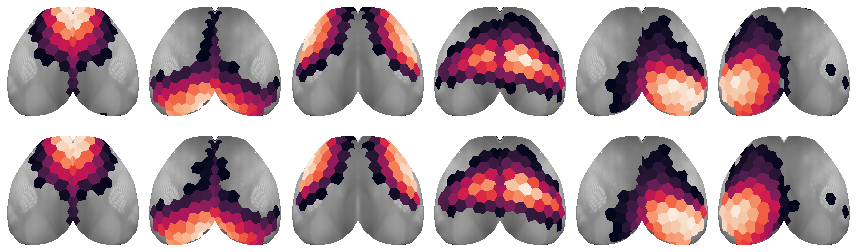

In [5]:
quick_show(compare['cosine']['tr_seed'], compare['correlation']['tr_seed'], 0.1)

In [6]:
gr_bo.pi_symmetry_score(compare['cosine']['pi'])

(
    {1: 0.997, 2: 0.969, 3: 0.986, 4: 0.937, 5: 0.367, 6: 0.008, -1: 0.711},
    {1: 1.0, 2: 0.87, 3: 0.974, 4: 0.948, 5: 0.649, 6: 0.701, -1: 0.857}
)

In [7]:
gr_bo.pi_symmetry_score(compare['correlation']['pi'])

(
    {1: 0.997, 2: 0.97, 3: 0.986, 4: 0.94, 5: 0.369, 6: 0.005, -1: 0.711},
    {1: 1.0, 2: 0.87, 3: 0.961, 4: 0.935, 5: 0.636, 6: 0.688, -1: 0.848}
)

In [8]:
compare_ca = {}
for metric in ['cosine', 'correlation']:
    gr_ca = Group(dist_metric=metric, **props_ca)
    _ = gr_ca.load_svinets()
    self = gr_ca
    self.perms, ct = self.align_group()

    tr_ct = gr_ca.project_vec(ct / np.nansum(ct, -2, keepdims=True))
    tr_ct = gr_ca.trim2d(tr_ct)
    
    dataaa = self._apply_perms()
    results_agg = self._aggregate_data(dataaa)
    
    pi_seed_avg_this_good = results_agg['gam_run']
    pi_seed_avg_this_good = pi_seed_avg_this_good / np.nansum(pi_seed_avg_this_good, -2, keepdims=True)
    pi_seed_avg_this_good = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(pi_seed_avg_this_good, 3), 2), 1), 0)

    tr_seed_avg_this_good = gr_ca.project_vec(pi_seed_avg_this_good)
    tr_seed_avg_this_good = gr_ca.trim2d(tr_seed_avg_this_good)
    
    compare_ca[metric] = {
        'pi': pi_seed_avg_this_good,
        'tr_ct': tr_ct,
        'tr_seed': tr_seed_avg_this_good,
    }

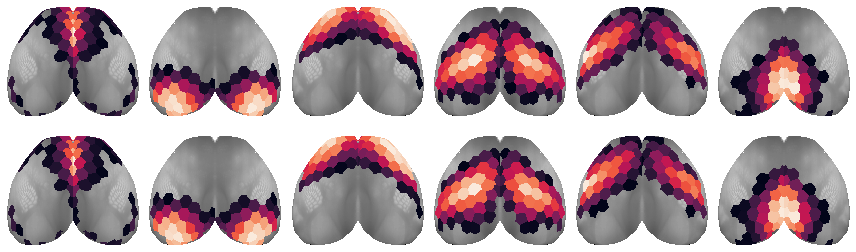

In [9]:
quick_show(compare_ca['cosine']['tr_seed'], compare_ca['correlation']['tr_seed'], 0.1)

In [10]:
gr_bo.pi_symmetry_score(compare_ca['cosine']['pi'])

(
    {1: 0.986, 2: 0.995, 3: 0.973, 4: 0.984, 5: 0.925, 6: 0.996, -1: 0.976},
    {1: 0.987, 2: 0.987, 3: 0.948, 4: 0.935, 5: 0.909, 6: 1.0, -1: 0.961}
)

In [11]:
gr_bo.pi_symmetry_score(compare_ca['correlation']['pi'])

(
    {1: 0.985, 2: 0.995, 3: 0.973, 4: 0.984, 5: 0.923, 6: 0.996, -1: 0.976},
    {1: 0.987, 2: 1.0, 3: 0.948, 4: 0.948, 5: 0.909, 6: 1.0, -1: 0.965}
)

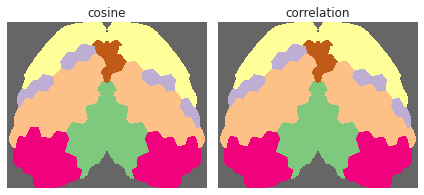

In [38]:
fig, axes = create_figure(1, 2, (6, 3))
for i, (lbl, v) in enumerate(compare_ca.items()):
    axes[i].imshow(v['tr_seed']['proj-top'][-1], 'Accent_r')
    axes[i].set_title(lbl)
remove_ticks(axes)
plt.show()

<matplotlib.lines.Line2D object at 0x7f0ae6e80070>

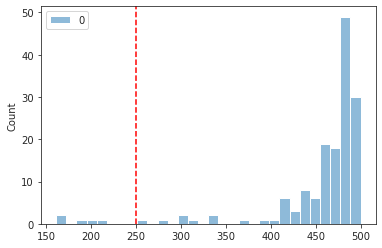

In [57]:
sns.histplot(results_agg['n_seeds'].values())
plt.axvline(250, ls='--', color='r')

In [58]:
bad_runs = {k: v for k, v in results_agg['n_seeds'].items() if v < 250 and 'run' in k}
bad_runs

{
    'sub-SLC03_ses-3_run-3': 198,
    'sub-SLC04_ses-1_run-7': 161,
    'sub-SLC04_ses-2_run-1': 185,
    'sub-SLC05_ses-1_run-1': 213
}

In [59]:
exclude = [tuple(i - 1 for i in mice.looper[k]) for k in bad_runs]
exclude = [(e[0], e[1], e[2] // 2) for e in exclude]
exclude

[(2, 2, 1), (3, 0, 3), (3, 1, 0), (4, 0, 0)]

In [60]:
compare_ca = {}
for metric in ['cosine', 'correlation']:
    gr_ca = Group(dist_metric=metric, **props_ca)
    _ = gr_ca.load_svinets()
    self = gr_ca
    self.perms, ct = self.align_group()

    tr_ct = gr_ca.project_vec(ct / np.nansum(ct, -2, keepdims=True))
    tr_ct = gr_ca.trim2d(tr_ct)
    
    dataaa = self._apply_perms()
    results_agg = self._aggregate_data(dataaa)
    
    pi_seed_avg_this_good = results_agg['gam_run'].copy()
    for i, j, k in exclude:
        pi_seed_avg_this_good[i, j, k] = np.nan

    pi_seed_avg_this_good = pi_seed_avg_this_good / np.nansum(pi_seed_avg_this_good, -2, keepdims=True)
    pi_seed_avg_this_good = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(pi_seed_avg_this_good, 3), 2), 1), 0)

    tr_seed_avg_this_good = gr_ca.project_vec(pi_seed_avg_this_good)
    tr_seed_avg_this_good = gr_ca.trim2d(tr_seed_avg_this_good)
    
    compare_ca[metric] = {
        'pi': pi_seed_avg_this_good,
        'tr_ct': tr_ct,
        'tr_seed': tr_seed_avg_this_good,
    }

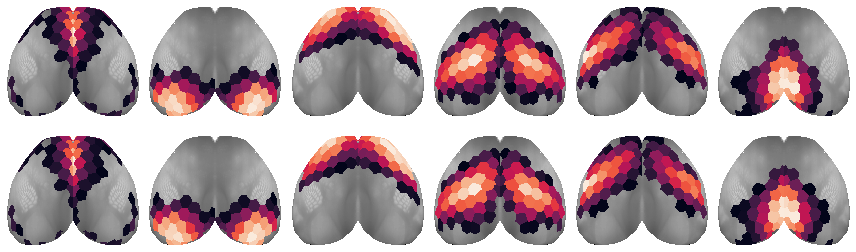

In [61]:
quick_show(compare_ca['cosine']['tr_seed'], compare_ca['correlation']['tr_seed'], 0.1)

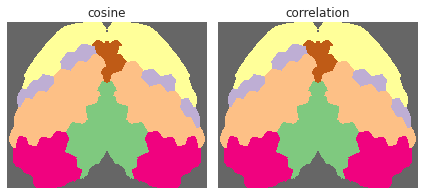

In [62]:
fig, axes = create_figure(1, 2, (6, 3))
for i, (lbl, v) in enumerate(compare_ca.items()):
    axes[i].imshow(v['tr_seed']['proj-top'][-1], 'Accent_r')
    axes[i].set_title(lbl)
remove_ticks(axes)
plt.show()

In [63]:
gr_bo.pi_symmetry_score(compare_ca['cosine']['pi'])

(
    {1: 0.984, 2: 0.995, 3: 0.972, 4: 0.985, 5: 0.923, 6: 0.996, -1: 0.976},
    {1: 0.987, 2: 1.0, 3: 0.948, 4: 0.948, 5: 0.909, 6: 1.0, -1: 0.965}
)

In [64]:
gr_bo.pi_symmetry_score(compare_ca['correlation']['pi'])

(
    {1: 0.984, 2: 0.995, 3: 0.972, 4: 0.984, 5: 0.922, 6: 0.996, -1: 0.975},
    {1: 0.987, 2: 1.0, 3: 0.948, 4: 0.948, 5: 0.909, 6: 1.0, -1: 0.965}
)

In [48]:
key = mice.get_key(10, 3, 1)
pi_seed_avg = dataaa[key]['gam']
pi_seed_avg = pi_seed_avg / np.nansum(pi_seed_avg, -2, keepdims=True)
pi_seed_avg = bn.nanmean(pi_seed_avg, 0)

tr_seed_avg = gr_ca.project_vec(pi_seed_avg)
tr_seed_avg = gr_ca.trim2d(tr_seed_avg)

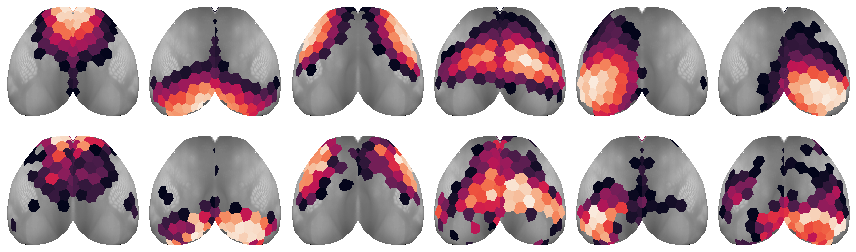

In [49]:
quick_show(tr, tr_seed_avg)

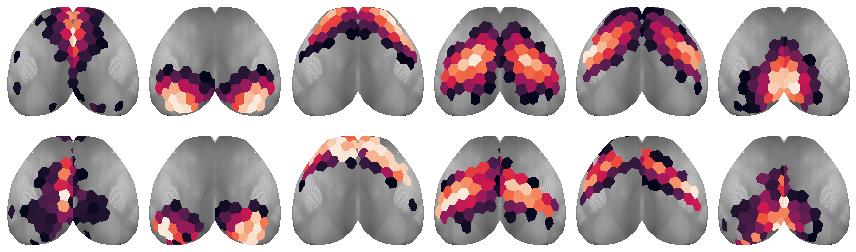

In [50]:
n_seeds = {}
for key, sv in self.svinets.items():
    n_seeds[key] = len(sv.gam_all)

meta_key = f"{self.mode.split('-')[0]}_{self.task}"
n_runs = {}
for key, (sub, ses, _) in self.mice.looper_agg.items():
    if sub == -1 or ses == -1:
        continue
    n_runs[key] = len(self.mice.combine_meta[meta_key][key])

<AxesSubplot:ylabel='Count'>

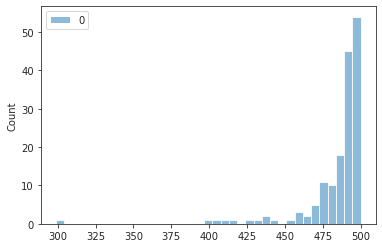

In [51]:
sns.histplot(n_seeds.values())

In [53]:
{k: v for k, v in n_seeds.items() if v < 400 and 'run' in k}

{'sub-SLC08_ses-3_run-5': 299}

In [54]:
results_agg = self.get_aggregate_data(dataaa, False)

In [55]:
results_agg['centroids'][9, 2, 0]

array([[0.10130077, 0.21698828,        nan, 0.10271377, 0.0997195 ,
        0.20758238, 0.22284781, 0.03213688, 0.10309789, 0.0934918 ,
        0.00655742, 0.03216581, 0.1641918 , 0.09486926, 0.03611944,
        0.05637146, 0.01418814, 0.03433075, 0.04822772, 0.1418673 ,
        0.007135  , 0.09629072, 0.00760251, 0.05385757, 0.0096818 ,
        0.09807679, 0.07576428, 0.06028102, 0.04227053, 0.00243938,
        0.00264655, 0.05611009, 0.0909822 , 0.12150832, 0.05851634,
        0.0047231 , 0.00261015, 0.0738865 , 0.01965885, 0.05348841,
        0.04565903, 0.01385742, 0.00440132, 0.06807819, 0.01644217,
        0.01762199, 0.05243964, 0.03579957, 0.02139182, 0.02852738,
        0.00753493, 0.00644415, 0.00755423, 0.01465928, 0.04044772,
        0.02764505, 0.00414063, 0.00535772, 0.01118466, 0.00129802,
        0.00444881, 0.00073069, 0.003012  , 0.00407319, 0.00735354,
        0.01654388, 0.00777601, 0.00264391, 0.00135409, 0.00348757,
        0.00969779, 0.00100848, 0.0013906 , 0.00578918, 0.00110345,
        0.00559232, 0.00265868, 0.10840795, 0.19160995,        nan,
        0.0940049 , 0.11804711, 0.18167602, 0.12750455, 0.04701924,
        0.13345787, 0.10705076, 0.08958127, 0.00748971, 0.18067226,
        0.03244213, 0.00073088, 0.06477841, 0.00434801, 0.04345194,
        0.11818349, 0.06699373, 0.01652307, 0.0638136 , 0.04452203,
        0.05985746, 0.00375479, 0.04687033, 0.06109166, 0.07222442,
        0.03785254, 0.00350688, 0.0039643 , 0.05060898, 0.08546042,
        0.08306935, 0.0344616 , 0.01768086, 0.00648184, 0.06280215,
        0.04163362, 0.05236909, 0.05621046, 0.01729047, 0.00566285,
        0.06183192, 0.03604885, 0.05352767, 0.05457369, 0.03487309,
        0.00896621, 0.00611923, 0.00867174, 0.00775237, 0.00539586,
        0.00883821, 0.01065241, 0.01309781, 0.00093264, 0.0006814 ,
        0.00083448, 0.00207926, 0.00334486, 0.00068157, 0.00202463,
        0.00068135, 0.00068137, 0.00068487, 0.00068161, 0.00081395,
        0.00088195, 0.0027443 , 0.00083405, 0.00076516, 0.00169506,
        0.00240363, 0.00068137, 0.00122702, 0.00078688],
       [0.00080626, 0.00048527,        nan, 0.00063099, 0.00049926,
        0.00048545, 0.00048563, 0.00050743, 0.00049532, 0.0007391 ,
        0.00048505, 0.00050508, 0.0004864 , 0.00049811, 0.00050098,
        0.02150265, 0.00050969, 0.00048636, 0.00300436, 0.00074616,
        0.00235201, 0.00049488, 0.00048505, 0.00945655, 0.00052012,
        0.00144082, 0.00049536, 0.00049235, 0.00048716, 0.00061308,
        0.00048515, 0.02033814, 0.00049456, 0.00050642, 0.00062393,
        0.00071342, 0.00077435, 0.00265957, 0.00555906, 0.00168044,
        0.0017136 , 0.00234263, 0.00080475, 0.00820784, 0.0006045 ,
        0.00190394, 0.00112469, 0.00255854, 0.00150503, 0.00113236,
        0.00350401, 0.01838996, 0.02539981, 0.00117611, 0.00301322,
        0.04712991, 0.02141849, 0.02831454, 0.03282897, 0.07386194,
        0.04157285, 0.16019512, 0.10942741, 0.06152325, 0.07025517,
        0.04261771, 0.06993592, 0.04421558, 0.16338288, 0.13371809,
        0.04347321, 0.15907197, 0.12471367, 0.12727021, 0.18919594,
        0.17413199, 0.07406693, 0.00135167, 0.00054067,        nan,
        0.00089994, 0.00873391, 0.00048538, 0.00048843, 0.00218707,
        0.00088486, 0.00070251, 0.00316075, 0.00049785, 0.00048676,
        0.00049233, 0.00048502, 0.00958464, 0.00048505, 0.000686  ,
        0.00049168, 0.0005071 , 0.00049508, 0.00089786, 0.00050515,
        0.01005852, 0.00049119, 0.00981708, 0.00049905, 0.00049852,
        0.00109107, 0.00048698, 0.00048536, 0.02283906, 0.00050092,
        0.00056849, 0.00247265, 0.00115711, 0.00057483, 0.00406433,
        0.00063961, 0.00234937, 0.00139705, 0.00318577, 0.00176449,
        0.01015753, 0.00366153, 0.00568271, 0.00107899, 0.01191017,
        0.00813377, 0.02258736, 0.01818898, 0.04309016, 0.04421722,
        0.03261941, 0.11125696, 0.01713807, 0.12595519, 0.17385649,
        0.16174863, 0.07875015, 0.13113091, 0.17241281, 0.14738398,

In [56]:
results_agg['centroids'].shape

(10, 3, 4, 6, 154)

In [57]:
pi_ct_avg = results_agg['centroids'] / np.nansum(results_agg['centroids'], -2, keepdims=True)
pi_ct_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_ct_avg, 2), 1), 0)

tr_ct_avg = gr_ca.project_vec(pi_ct_avg)
tr_ct_avg = gr_ca.trim2d(tr_ct_avg)

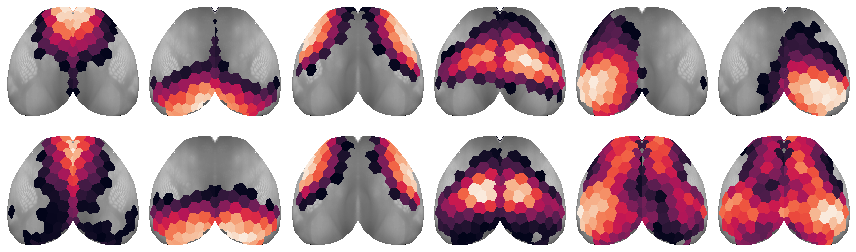

In [58]:
quick_show(tr, tr_ct_avg, 0.1)

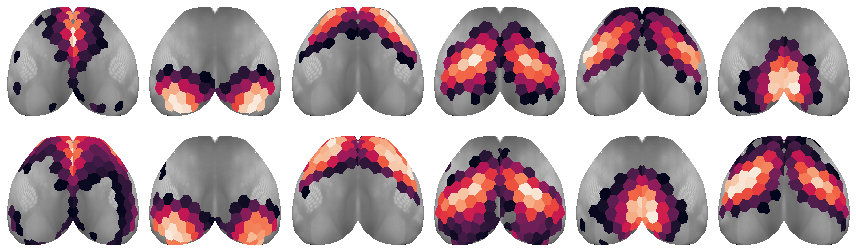

In [33]:
pi_seed_avg_this_good = results_agg['gam_run']
pi_seed_avg_this_good = pi_seed_avg_this_good / np.nansum(pi_seed_avg_this_good, -2, keepdims=True)
pi_seed_avg_this_good = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(pi_seed_avg_this_good, 3), 2), 1), 0)

tr_seed_avg_this_good = gr_ca.project_vec(pi_seed_avg_this_good)
tr_seed_avg_this_good = gr_ca.trim2d(tr_seed_avg_this_good)

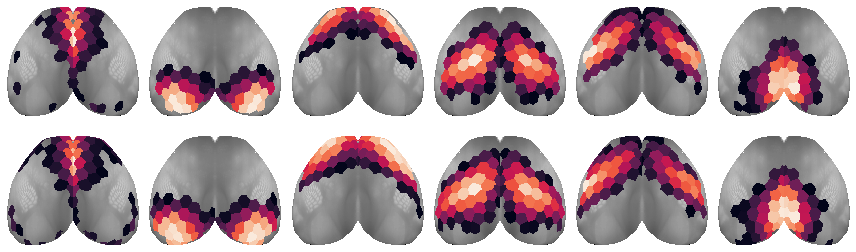

In [34]:
quick_show(tr, tr_seed_avg_this_good, 0.1)

In [37]:
h = sp_stats.entropy(pi_seed_avg_this_good) / np.log(6)
tr_h = gr_ca.project_vec(h, add_disjoint=False)
tr_h = gr_ca.trim2d(tr_h)

<matplotlib.image.AxesImage object at 0x7f26e0188850>

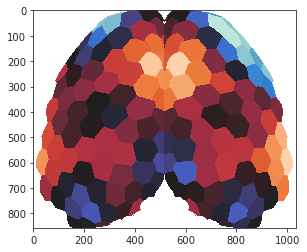

In [42]:
plt.imshow(mwh(tr_h['proj-top'][0] == 0, tr_h['proj-top'][0]), cmap='icefire')

In [21]:
results_agg['centroids'][9, 2, 0]

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan

In [ ]:
pi_seed_avg2 = output['gam_run'][9, 2, 0]
pi_seed_avg2 = pi_seed_avg2 / np.nansum(pi_seed_avg2, -2, keepdims=True)
pi_seed_avg2 = bn.nanmean(pi_seed_avg2, 0)

tr_seed_avg2 = gr_ca.project_vec(pi_seed_avg2)
tr_seed_avg2 = gr_ca.trim2d(tr_seed_avg2)

In [ ]:
good = np.isnan(pi_seed_avg).sum(0) == 0
good2 = np.isnan(pi_seed_avg2).sum(0) == 0
np.array_equal(good,good2)

In [27]:
top_n = 100
num_nodes = len(self.n2l)

i, j, k = gam.shape[:3]
centroid_runs = np_nans((i, j, k, self.num_k, num_nodes))
top_seeds = np.zeros((i, j, k, top_n), dtype=int)
centroid_runs.shape, top_seeds.shape

looper = itertools.product(
    range(i), range(j), range(k))
missing_runs = []

for i, j, k in looper:
    if (i, j, k) != (9, 2, 0):
        continue
    data = gam[i, j, k]
    nan_seeds = np.isnan(data).sum(-1).mean(-1)
    nan_seeds = np.where(nan_seeds == num_nodes)[0]
    good_seeds = np.delete(range(len(data)), nan_seeds)
    if not len(good_seeds):
        missing_runs.append((i, j, k))
        continue
    data = data[good_seeds]
    data_flat = data.reshape(-1, num_nodes)
    nonan = np.isnan(data_flat).sum(0) == 0
    print(i, j, k, nonan.sum())

    centroids = np.zeros((self.num_k, num_nodes))
    _centroids, _ = fit_kmeans(
        data=data_flat[:, nonan],
        n_clusters=self.num_k,
        match_metric='euclidean',
        random_state=self.mice.cfg.random_state,
    )
    centroids[:, nonan] = _centroids

    global_mapping = self.align_centroid_to_structs(
        pi_mv=centroids,
        metric='correlation',# self.dist_metric,
        global_order=self.global_order,
    )
    centroids = centroids[global_mapping]
    centroids[:, ~nonan] = np.nan
    centroid_runs[i, j, k] = centroids

9 2 0 134

In [28]:
i, j, k

(9, 2, 3)

In [20]:
len(nan_seeds), len(good_seeds)

(40, 460)

In [21]:
n_seeds[mice.get_key(10, 3, 1)]

460

In [22]:
centroid_runs[9, 2, 0].shape

(6, 154)

In [23]:
centroid_runs[9, 2, 0].shape

(6, 154)

In [30]:
pi_ct_after_agg = centroid_runs[9, 2, 0]
pi_ct_after_agg = pi_ct_after_agg / np.nansum(pi_ct_after_agg, -2, keepdims=True)

tr_ct_after_agg = gr_ca.project_vec(pi_ct_after_agg)
tr_ct_after_agg = gr_ca.trim2d(tr_ct_after_agg)

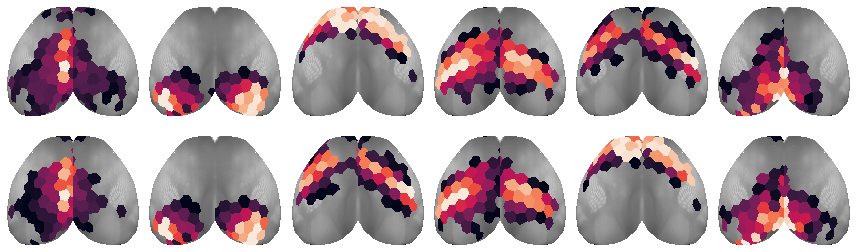

In [31]:
quick_show(tr_seed_avg, tr_ct_after_agg, 0.05)

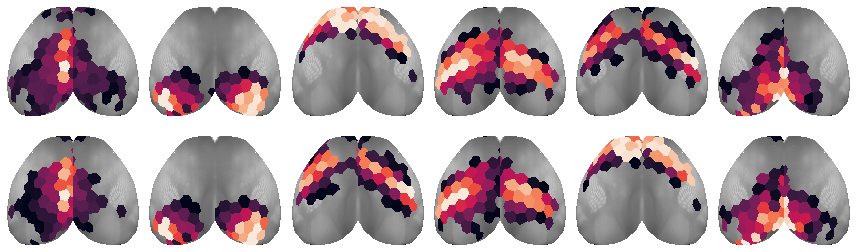

In [4]:
# gr_ca = Group(**props_ca).fit_group(force=True, final_align=True, n_top=0)
# gr_bo = Group(**props_bo).fit_group(force=True, final_align=True, n_top=0)

In [5]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

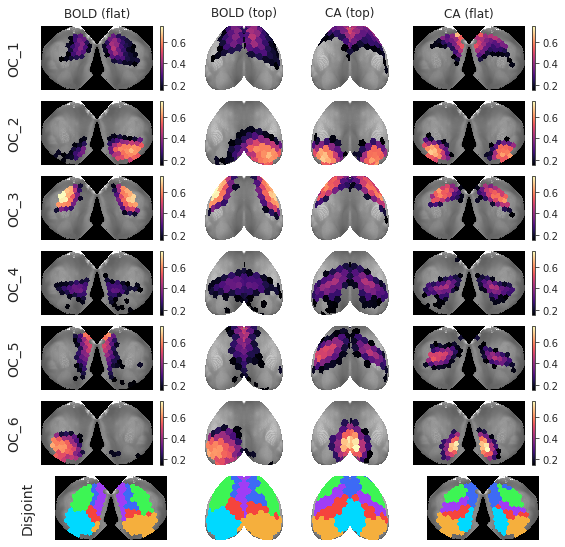

In [6]:
proj_ca = gr_ca.project_vec(gr_ca.grp_pi)
proj_bo = gr_bo.project_vec(gr_bo.grp_pi)

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.15,
)

In [7]:
def align(self, data: Union[np.ndarray, dict] = None):
    data = data if data is not None else self.load_svinets()
    accepted_runs, good_global = _good_nodes(self, data, 0.90)
    return accepted_runs, good_global

def _good_nodes(self, data: Union[np.ndarray, dict] = None, freq_q: float = 0.90):
    data = data if data is not None else self.load_svinets()
    node_presence = collections.defaultdict(list)
    ctr = 0
    if isinstance(data, np.ndarray):
        i, j, k = data.shape[:3]
        looper = itertools.product(
            range(i), range(j), range(k))
        for i, j, k in looper:
            x = data[i, j, k]
            good = np.where(np.isnan(x).sum(0) == 0)[0]
            if not len(good):
                continue
            ctr += 1
            for n in good:
                node_presence[n].append((i, j, k))
    elif isinstance(data, dict):
        for key, sv in data.items():
            if 'run' not in key:
                continue
            good = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
            if not len(good):
                continue
            ctr += 1
            for n in good:
                node_presence[n].append(key)

    node_presence = dict(sorted(node_presence.items()))
    # print(node_presence)
    freq = {
        n: len(v) / ctr for n, v
        in node_presence.items()
    }
    good_global = np.array([
        n for n, f in freq.items()
        if f > freq_q
    ])
    accepted_runs = []
    if isinstance(data, np.ndarray):
        i, j, k = data.shape[:3]
        looper = itertools.product(
            range(i), range(j), range(k))
        for i, j, k in looper:
            x = data[i, j, k]
            good = np.where(np.isnan(x).sum(0) == 0)[0]
            if all(e in good for e in good_global):
                accepted_runs.append((i, j, k))
    elif isinstance(data, dict):
        for key, sv in data.items():
            if 'run' not in key:
                continue
            good = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
            if all(e in good for e in good_global):
                accepted_runs.append(key)
    return accepted_runs, good_global

In [8]:
accepted_runs, good_global = align(gr_bo)
len(accepted_runs), len(good_global)

(63, 151)

In [9]:
accepted_runs, good_global = align(gr_bo, gr_bo.run_centroids)
len(accepted_runs), len(good_global)

(22, 149)

In [10]:
data = gr_bo.run_centroids
i, j, k = data.shape[:3]
looper = itertools.product(
    range(i), range(j), range(k))

bad_runs = []
n_good = np.zeros((i, j, k), int)
for i, j, k in looper:
    x = data[i, j, k]
    good = np.where(np.isnan(x).sum(0) == 0)[0]
    n_good[i, j, k] = len(good)
    
    if len(good) == 0:
        bad_runs.append((i, j, k))
        continue
        
len(bad_runs)

84

In [11]:
np.prod(data.shape[:3])

120

In [12]:
120 - 84

36

In [13]:
len(good)

0

In [14]:
collections.Counter(n_good.ravel()).most_common()

[
    (0, 84),
    (141, 6),
    (137, 5),
    (143, 4),
    (145, 3),
    (144, 3),
    (136, 3),
    (146, 2),
    (150, 2),
    (148, 2),
    (135, 1),
    (132, 1),
    (130, 1),
    (139, 1),
    (149, 1),
    (138, 1)
]

In [15]:
n_good[9]

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [16]:
gr_ca

<analysis.group.Group object at 0x7ffbdc06a8e0>

In [17]:
(~np.isnan(gr_ca.run_centroids[9])).sum()

0

In [23]:
key = mice.get_key(10, 3, 1)
sv = SVINET(mice, num_k, perc, key, 'ca2')

current expt: 'p25-sample'

In [24]:
_ = sv.load_results()

[PROGRESS] loading 'real-k6-p25-sample-euclidean-linksampling-(2022_04_25)' from
'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/results/SVINET/n-
128*3_ca2_rest_pearson_sub-SLC10_ses-3_run-1'

[PROGRESS] results loaded

In [32]:
data = gr_ca.run_centroids
i, j, k = data.shape[:3]
looper = itertools.product(
    range(i), range(j), range(j))

ctr = 0
run_diagnosis = np.zeros((i, j, k, 2))
bad_runs = []
for i, j, k in looper:
    x = data[i, j, k]
    good = np.where(np.isnan(x).sum(0) == 0)[0]
    counts = collections.Counter(np.isnan(x).sum(0))
    run_diagnosis[i, j, k] = [counts.get(i, 0) for i in [0, 5]]
    
    if not len(good):
        bad_runs.append((i, j, k))
        continue

    ctr += 1
    
bad_runs2 = list(zip(*np.where(run_diagnosis[..., 1] == data.shape[-1])))
set(bad_runs) == set(bad_runs2)

True

In [37]:
good_runs = list(zip(*np.where(run_diagnosis[..., 0] > 0)))

In [46]:
for i, j, k in good_runs:
    print(i, j, k, run_diagnosis[i, j, k, 0])

0 0 0 139.0

0 0 1 134.0

0 1 0 141.0

0 1 1 134.0

1 0 0 138.0

1 0 1 139.0

1 1 0 132.0

1 1 1 129.0

2 0 0 135.0

2 0 1 115.0

2 1 0 128.0

2 1 1 124.0

3 0 0 126.0

3 0 1 137.0

3 1 0 122.0

3 1 1 122.0

4 0 0 132.0

4 0 1 124.0

4 1 0 138.0

4 1 1 101.0

5 0 0 143.0

5 0 1 147.0

5 1 0 142.0

5 1 1 140.0

6 0 0 140.0

6 0 1 128.0

6 1 0 132.0

6 1 1 138.0

7 0 0 147.0

7 0 1 146.0

7 1 0 138.0

7 1 1 135.0

8 0 0 123.0

8 0 1 130.0

8 1 0 134.0

8 1 1 134.0

In [47]:
np.unique(run_diagnosis.sum(-1))

array([  0., 154.])

In [48]:
np.where(run_diagnosis.sum(-1) == 0)

(
    array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7,
       7, 7, 8, 8, 8, 9, 9, 9]),
    array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2]),
    array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])
)

In [49]:
run_diagnosis[0, 0, 3]

array([0., 0.])

[0, 154]

In [58]:
x = gr_ca.run_centroids[4, 1, 1]
x.shape

(5, 154)

In [59]:
tr = gr_ca.project_vec(x)
tr = gr_ca.trim2d(tr)

<matplotlib.image.AxesImage object at 0x7fd7908d00d0>

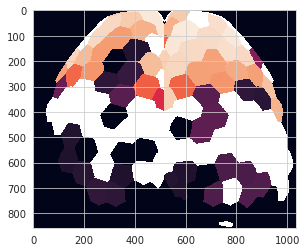

In [68]:
plt.imshow(tr['proj-top'][2])

In [69]:
svinets = gr_ca.load_svinets()

In [71]:
key = mice.get_key(5, 2, 3)
sv = svinets[key]

In [73]:
tr2 = gr_ca.project_vec(sv.pi)
tr2 = gr_ca.trim2d(tr2)

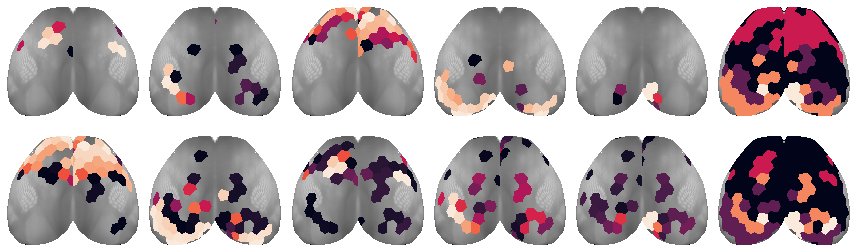

In [74]:
quick_show(tr, tr2)

In [49]:

key = 'sub-SLC08_ses-1_run-5'
mode = 'bold-lite'
gr = Group(mice, num_k, mode=mode)
sv = SVINET(mice, num_k, perc, key, mode)
self = sv

current expt: 'p10-sample'

In [50]:
_ = sv.load_runs()

[PROGRESS] experiment loaded: 'k = 5, p10-sample',  total # runs:  488

[PROGRESS] some runs were excluded:     12 x k = 4

In [56]:
run_name = 'n101-k5-mmsb-seed49-linksampling'
run = sv._runs['p10-sample'][run_name]
list(run)

[
    'valid',
    'gamma_sv',
    'lambda_sv',
    'community_sv',
    'membership_sv',
    'partition_sv',
    'num_missing',
    'num_overlap',
    'gam',
    'lam',
    'pi'
]

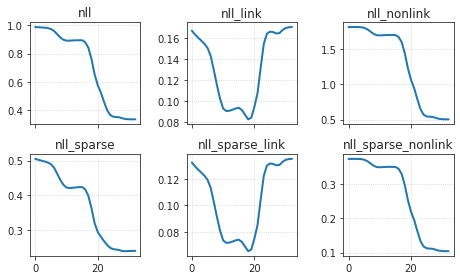

In [57]:
fig, axes = create_figure(2, 3, (6.5, 4), 'all')
data2p = {k: v for k, v in run['valid'].items() if 'nll' in k}
for ax, (k, x) in zip(axes.ravel(), data2p.items()):
    ax.plot(x, lw=2)
    ax.set_title(k)
    ax.grid()

In [58]:
x = run['gam'].copy()
x /= x.sum(-2, keepdims=True)

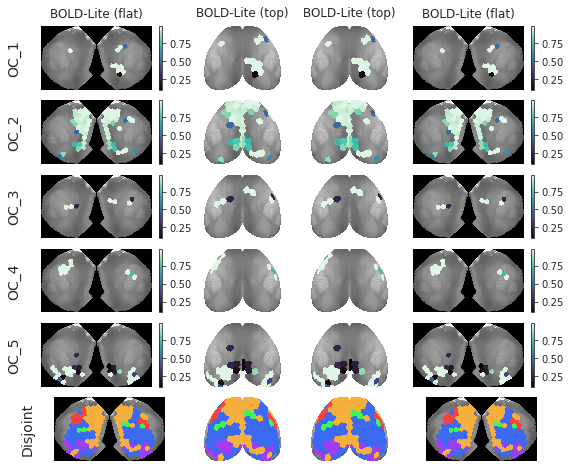

In [59]:
tr1 = gr.project_vec(x)
tr2 = gr.project_vec(run['pi'])
_ = gr.show(tr1, tr2, cmaps=('mako',) * 2, fix_cmap=False)

<matplotlib.image.AxesImage object at 0x7f3b4647f5b0>

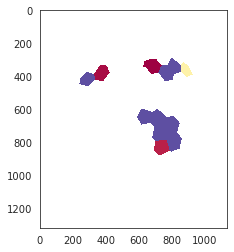

In [60]:
plt.imshow(mwh(tr1['top'][0] < 0.05, tr1['top'][0]), cmap='Spectral')

In [61]:
data = sv._cat_data(raw=True, which=sv.match_using)
sv.match_using, data.shape

('gam', (2440, 154))

In [62]:
centroids, _ = fit_kmeans(
    data=data,
    n_clusters=sv.num_k,
    match_metric=sv.match_metric,
    random_state=sv.mice.cfg.random_state,
    normalize=sv.normalize,
    verbose=True,
)
centroids.shape

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

(5, 154)

In [63]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=centroids,
    dist_metric='correlation',
    cortex_only=True,
    global_order=False,
    assert_equal=False,
)

In [64]:
self.centroids = centroids[global_mapping]

In [65]:
x = centroids.copy()
x /= x.sum(-2, keepdims=True)
tr1 = gr.project_vec(x)
tr1 = gr.trim2d(tr1)

x = self.centroids.copy()
x /= x.sum(-2, keepdims=True)
tr2 = gr.project_vec(x)
tr2 = gr.trim2d(tr2)

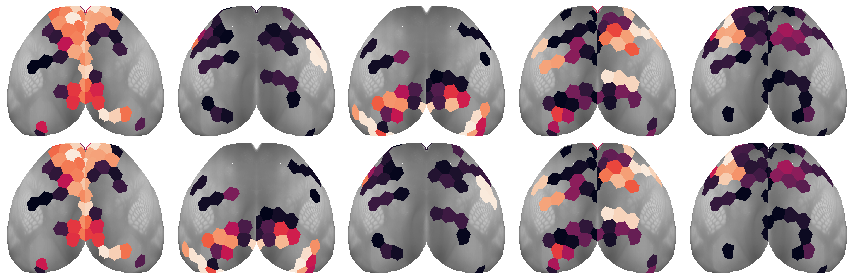

In [66]:
quick_show(tr1, tr2)

In [67]:
self.perms = self._perms(data, 'correlation')

[PROGRESS] find best mappings: done

In [68]:
self._align()

warning type 1 at n101-k5-mmsb-seed1-linksampling

warning type 1 at n101-k5-mmsb-seed2-linksampling

warning type 1 at n101-k5-mmsb-seed3-linksampling

warning type 1 at n101-k5-mmsb-seed5-linksampling

warning type 1 at n101-k5-mmsb-seed6-linksampling

warning type 1 at n101-k5-mmsb-seed7-linksampling

warning type 1 at n101-k5-mmsb-seed8-linksampling

warning type 1 at n101-k5-mmsb-seed9-linksampling

warning type 1 at n101-k5-mmsb-seed10-linksampling

warning type 1 at n101-k5-mmsb-seed11-linksampling

warning type 1 at n101-k5-mmsb-seed12-linksampling

warning type 1 at n101-k5-mmsb-seed13-linksampling

warning type 1 at n101-k5-mmsb-seed14-linksampling

warning type 1 at n101-k5-mmsb-seed15-linksampling

warning type 1 at n101-k5-mmsb-seed16-linksampling

warning type 1 at n101-k5-mmsb-seed17-linksampling

warning type 1 at n101-k5-mmsb-seed18-linksampling

warning type 1 at n101-k5-mmsb-seed19-linksampling

warning type 1 at n101-k5-mmsb-seed20-linksampling

warning type 1 at n101-k5-mmsb-seed21-linksampling

warning type 1 at n101-k5-mmsb-seed22-linksampling

warning type 1 at n101-k5-mmsb-seed24-linksampling

warning type 1 at n101-k5-mmsb-seed25-linksampling

warning type 1 at n101-k5-mmsb-seed26-linksampling

warning type 1 at n101-k5-mmsb-seed27-linksampling

warning type 1 at n101-k5-mmsb-seed28-linksampling

warning type 1 at n101-k5-mmsb-seed29-linksampling

warning type 1 at n101-k5-mmsb-seed31-linksampling

warning type 1 at n101-k5-mmsb-seed32-linksampling

warning type 1 at n101-k5-mmsb-seed33-linksampling

warning type 1 at n101-k5-mmsb-seed34-linksampling

warning type 1 at n101-k5-mmsb-seed36-linksampling

warning type 1 at n101-k5-mmsb-seed37-linksampling

warning type 1 at n101-k5-mmsb-seed38-linksampling

warning type 1 at n101-k5-mmsb-seed41-linksampling

warning type 1 at n101-k5-mmsb-seed42-linksampling

warning type 1 at n101-k5-mmsb-seed43-linksampling

warning type 1 at n101-k5-mmsb-seed44-linksampling

warning type 1 at n101-k5-mmsb-seed45-linksampling

warning type 1 at n101-k5-mmsb-seed46-linksampling

warning type 1 at n101-k5-mmsb-seed48-linksampling

warning type 1 at n101-k5-mmsb-seed49-linksampling

warning type 1 at n101-k5-mmsb-seed50-linksampling

warning type 1 at n101-k5-mmsb-seed51-linksampling

warning type 1 at n101-k5-mmsb-seed53-linksampling

warning type 1 at n101-k5-mmsb-seed54-linksampling

warning type 1 at n101-k5-mmsb-seed55-linksampling

warning type 1 at n101-k5-mmsb-seed56-linksampling

warning type 1 at n101-k5-mmsb-seed57-linksampling

warning type 1 at n101-k5-mmsb-seed58-linksampling

warning type 1 at n101-k5-mmsb-seed60-linksampling

warning type 1 at n101-k5-mmsb-seed61-linksampling

warning type 1 at n101-k5-mmsb-seed62-linksampling

warning type 1 at n101-k5-mmsb-seed63-linksampling

warning type 1 at n101-k5-mmsb-seed64-linksampling

warning type 1 at n101-k5-mmsb-seed65-linksampling

warning type 1 at n101-k5-mmsb-seed66-linksampling

warning type 1 at n101-k5-mmsb-seed68-linksampling

warning type 1 at n101-k5-mmsb-seed69-linksampling

warning type 1 at n101-k5-mmsb-seed70-linksampling

warning type 1 at n101-k5-mmsb-seed71-linksampling

warning type 1 at n101-k5-mmsb-seed72-linksampling

warning type 1 at n101-k5-mmsb-seed73-linksampling

warning type 1 at n101-k5-mmsb-seed74-linksampling

warning type 1 at n101-k5-mmsb-seed75-linksampling

warning type 1 at n101-k5-mmsb-seed77-linksampling

warning type 1 at n101-k5-mmsb-seed78-linksampling

warning type 1 at n101-k5-mmsb-seed79-linksampling

warning type 1 at n101-k5-mmsb-seed80-linksampling

warning type 1 at n101-k5-mmsb-seed81-linksampling

warning type 1 at n101-k5-mmsb-seed82-linksampling

warning type 1 at n101-k5-mmsb-seed83-linksampling

warning type 1 at n101-k5-mmsb-seed84-linksampling

warning type 1 at n101-k5-mmsb-seed85-linksampling

warning type 1 at n101-k5-mmsb-seed86-linksampling

warning type 1 at n101-k5-mmsb-seed87-linksampling

warning type 1 at n101-k5-mmsb-seed89-linksampling

warning type 1 at n101-k5-mmsb-seed90-linksampling

warning type 1 at n101-k5-mmsb-seed91-linksampling

warning type 1 at n101-k5-mmsb-seed92-linksampling

warning type 1 at n101-k5-mmsb-seed95-linksampling

warning type 1 at n101-k5-mmsb-seed96-linksampling

warning type 1 at n101-k5-mmsb-seed97-linksampling

warning type 1 at n101-k5-mmsb-seed99-linksampling

warning type 1 at n101-k5-mmsb-seed100-linksampling

warning type 1 at n101-k5-mmsb-seed101-linksampling

warning type 1 at n101-k5-mmsb-seed102-linksampling

warning type 1 at n101-k5-mmsb-seed103-linksampling

warning type 1 at n101-k5-mmsb-seed105-linksampling

warning type 1 at n101-k5-mmsb-seed106-linksampling

warning type 1 at n101-k5-mmsb-seed107-linksampling

warning type 1 at n101-k5-mmsb-seed108-linksampling

warning type 1 at n101-k5-mmsb-seed109-linksampling

warning type 1 at n101-k5-mmsb-seed111-linksampling

warning type 1 at n101-k5-mmsb-seed112-linksampling

warning type 1 at n101-k5-mmsb-seed113-linksampling

warning type 1 at n101-k5-mmsb-seed114-linksampling

warning type 1 at n101-k5-mmsb-seed115-linksampling

warning type 1 at n101-k5-mmsb-seed116-linksampling

warning type 1 at n101-k5-mmsb-seed117-linksampling

warning type 1 at n101-k5-mmsb-seed118-linksampling

warning type 1 at n101-k5-mmsb-seed119-linksampling

warning type 1 at n101-k5-mmsb-seed121-linksampling

warning type 1 at n101-k5-mmsb-seed122-linksampling

warning type 1 at n101-k5-mmsb-seed123-linksampling

warning type 1 at n101-k5-mmsb-seed124-linksampling

warning type 1 at n101-k5-mmsb-seed126-linksampling

warning type 1 at n101-k5-mmsb-seed128-linksampling

warning type 1 at n101-k5-mmsb-seed129-linksampling

warning type 1 at n101-k5-mmsb-seed131-linksampling

warning type 1 at n101-k5-mmsb-seed133-linksampling

warning type 1 at n101-k5-mmsb-seed134-linksampling

warning type 1 at n101-k5-mmsb-seed135-linksampling

warning type 1 at n101-k5-mmsb-seed136-linksampling

warning type 1 at n101-k5-mmsb-seed137-linksampling

warning type 1 at n101-k5-mmsb-seed138-linksampling

warning type 1 at n101-k5-mmsb-seed140-linksampling

warning type 1 at n101-k5-mmsb-seed141-linksampling

warning type 1 at n101-k5-mmsb-seed142-linksampling

warning type 1 at n101-k5-mmsb-seed143-linksampling

warning type 1 at n101-k5-mmsb-seed144-linksampling

warning type 1 at n101-k5-mmsb-seed145-linksampling

warning type 1 at n101-k5-mmsb-seed146-linksampling

warning type 1 at n101-k5-mmsb-seed147-linksampling

warning type 1 at n101-k5-mmsb-seed148-linksampling

warning type 1 at n101-k5-mmsb-seed149-linksampling

warning type 1 at n101-k5-mmsb-seed150-linksampling

warning type 1 at n101-k5-mmsb-seed152-linksampling

warning type 1 at n101-k5-mmsb-seed153-linksampling

warning type 1 at n101-k5-mmsb-seed154-linksampling

warning type 1 at n101-k5-mmsb-seed155-linksampling

warning type 1 at n101-k5-mmsb-seed156-linksampling

warning type 1 at n101-k5-mmsb-seed157-linksampling

warning type 1 at n101-k5-mmsb-seed158-linksampling

warning type 1 at n101-k5-mmsb-seed159-linksampling

warning type 1 at n101-k5-mmsb-seed160-linksampling

warning type 1 at n101-k5-mmsb-seed161-linksampling

warning type 1 at n101-k5-mmsb-seed162-linksampling

warning type 1 at n101-k5-mmsb-seed163-linksampling

warning type 1 at n101-k5-mmsb-seed164-linksampling

warning type 1 at n101-k5-mmsb-seed165-linksampling

warning type 1 at n101-k5-mmsb-seed166-linksampling

warning type 1 at n101-k5-mmsb-seed167-linksampling

warning type 1 at n101-k5-mmsb-seed169-linksampling

warning type 1 at n101-k5-mmsb-seed170-linksampling

warning type 1 at n101-k5-mmsb-seed171-linksampling

warning type 1 at n101-k5-mmsb-seed172-linksampling

warning type 1 at n101-k5-mmsb-seed174-linksampling

warning type 1 at n101-k5-mmsb-seed175-linksampling

warning type 1 at n101-k5-mmsb-seed177-linksampling

warning type 1 at n101-k5-mmsb-seed178-linksampling

warning type 1 at n101-k5-mmsb-seed179-linksampling

warning type 1 at n101-k5-mmsb-seed180-linksampling

warning type 1 at n101-k5-mmsb-seed181-linksampling

warning type 1 at n101-k5-mmsb-seed183-linksampling

warning type 1 at n101-k5-mmsb-seed184-linksampling

warning type 1 at n101-k5-mmsb-seed185-linksampling

warning type 1 at n101-k5-mmsb-seed186-linksampling

warning type 1 at n101-k5-mmsb-seed187-linksampling

warning type 1 at n101-k5-mmsb-seed188-linksampling

warning type 1 at n101-k5-mmsb-seed192-linksampling

warning type 1 at n101-k5-mmsb-seed195-linksampling

warning type 1 at n101-k5-mmsb-seed196-linksampling

warning type 1 at n101-k5-mmsb-seed197-linksampling

warning type 1 at n101-k5-mmsb-seed199-linksampling

warning type 1 at n101-k5-mmsb-seed200-linksampling

warning type 1 at n101-k5-mmsb-seed201-linksampling

warning type 1 at n101-k5-mmsb-seed202-linksampling

warning type 1 at n101-k5-mmsb-seed204-linksampling

warning type 1 at n101-k5-mmsb-seed205-linksampling

warning type 1 at n101-k5-mmsb-seed206-linksampling

warning type 1 at n101-k5-mmsb-seed208-linksampling

warning type 1 at n101-k5-mmsb-seed209-linksampling

warning type 1 at n101-k5-mmsb-seed210-linksampling

warning type 1 at n101-k5-mmsb-seed211-linksampling

warning type 1 at n101-k5-mmsb-seed213-linksampling

warning type 1 at n101-k5-mmsb-seed214-linksampling

warning type 1 at n101-k5-mmsb-seed215-linksampling

warning type 1 at n101-k5-mmsb-seed216-linksampling

warning type 1 at n101-k5-mmsb-seed217-linksampling

warning type 1 at n101-k5-mmsb-seed218-linksampling

warning type 1 at n101-k5-mmsb-seed220-linksampling

warning type 1 at n101-k5-mmsb-seed222-linksampling

warning type 1 at n101-k5-mmsb-seed223-linksampling

warning type 1 at n101-k5-mmsb-seed225-linksampling

warning type 1 at n101-k5-mmsb-seed226-linksampling

warning type 1 at n101-k5-mmsb-seed228-linksampling

warning type 1 at n101-k5-mmsb-seed229-linksampling

warning type 1 at n101-k5-mmsb-seed230-linksampling

warning type 1 at n101-k5-mmsb-seed231-linksampling

warning type 1 at n101-k5-mmsb-seed232-linksampling

warning type 1 at n101-k5-mmsb-seed233-linksampling

warning type 1 at n101-k5-mmsb-seed234-linksampling

warning type 1 at n101-k5-mmsb-seed235-linksampling

warning type 1 at n101-k5-mmsb-seed236-linksampling

warning type 1 at n101-k5-mmsb-seed237-linksampling

warning type 1 at n101-k5-mmsb-seed238-linksampling

warning type 1 at n101-k5-mmsb-seed240-linksampling

warning type 1 at n101-k5-mmsb-seed243-linksampling

warning type 1 at n101-k5-mmsb-seed244-linksampling

warning type 1 at n101-k5-mmsb-seed245-linksampling

warning type 1 at n101-k5-mmsb-seed246-linksampling

warning type 1 at n101-k5-mmsb-seed247-linksampling

warning type 1 at n101-k5-mmsb-seed248-linksampling

warning type 1 at n101-k5-mmsb-seed249-linksampling

warning type 1 at n101-k5-mmsb-seed250-linksampling

warning type 1 at n101-k5-mmsb-seed251-linksampling

warning type 1 at n101-k5-mmsb-seed253-linksampling

warning type 1 at n101-k5-mmsb-seed255-linksampling

warning type 1 at n101-k5-mmsb-seed256-linksampling

warning type 1 at n101-k5-mmsb-seed257-linksampling

warning type 1 at n101-k5-mmsb-seed260-linksampling

warning type 1 at n101-k5-mmsb-seed261-linksampling

warning type 1 at n101-k5-mmsb-seed262-linksampling

warning type 1 at n101-k5-mmsb-seed264-linksampling

warning type 1 at n101-k5-mmsb-seed266-linksampling

warning type 1 at n101-k5-mmsb-seed267-linksampling

warning type 1 at n101-k5-mmsb-seed269-linksampling

warning type 1 at n101-k5-mmsb-seed270-linksampling

warning type 1 at n101-k5-mmsb-seed271-linksampling

warning type 1 at n101-k5-mmsb-seed272-linksampling

warning type 1 at n101-k5-mmsb-seed273-linksampling

warning type 1 at n101-k5-mmsb-seed275-linksampling

warning type 1 at n101-k5-mmsb-seed277-linksampling

warning type 1 at n101-k5-mmsb-seed279-linksampling

warning type 1 at n101-k5-mmsb-seed280-linksampling

warning type 1 at n101-k5-mmsb-seed281-linksampling

warning type 1 at n101-k5-mmsb-seed282-linksampling

warning type 1 at n101-k5-mmsb-seed283-linksampling

warning type 1 at n101-k5-mmsb-seed284-linksampling

warning type 1 at n101-k5-mmsb-seed285-linksampling

warning type 1 at n101-k5-mmsb-seed286-linksampling

warning type 1 at n101-k5-mmsb-seed287-linksampling

warning type 1 at n101-k5-mmsb-seed288-linksampling

warning type 1 at n101-k5-mmsb-seed290-linksampling

warning type 1 at n101-k5-mmsb-seed291-linksampling

warning type 1 at n101-k5-mmsb-seed292-linksampling

warning type 1 at n101-k5-mmsb-seed293-linksampling

warning type 1 at n101-k5-mmsb-seed294-linksampling

warning type 1 at n101-k5-mmsb-seed295-linksampling

warning type 1 at n101-k5-mmsb-seed296-linksampling

warning type 1 at n101-k5-mmsb-seed297-linksampling

warning type 1 at n101-k5-mmsb-seed298-linksampling

warning type 1 at n101-k5-mmsb-seed299-linksampling

warning type 1 at n101-k5-mmsb-seed300-linksampling

warning type 1 at n101-k5-mmsb-seed301-linksampling

warning type 1 at n101-k5-mmsb-seed302-linksampling

warning type 1 at n101-k5-mmsb-seed303-linksampling

warning type 1 at n101-k5-mmsb-seed304-linksampling

warning type 1 at n101-k5-mmsb-seed305-linksampling

warning type 1 at n101-k5-mmsb-seed307-linksampling

warning type 1 at n101-k5-mmsb-seed308-linksampling

warning type 1 at n101-k5-mmsb-seed309-linksampling

warning type 1 at n101-k5-mmsb-seed310-linksampling

warning type 1 at n101-k5-mmsb-seed311-linksampling

warning type 1 at n101-k5-mmsb-seed313-linksampling

warning type 1 at n101-k5-mmsb-seed316-linksampling

warning type 1 at n101-k5-mmsb-seed317-linksampling

warning type 1 at n101-k5-mmsb-seed318-linksampling

warning type 1 at n101-k5-mmsb-seed319-linksampling

warning type 1 at n101-k5-mmsb-seed320-linksampling

warning type 1 at n101-k5-mmsb-seed321-linksampling

warning type 1 at n101-k5-mmsb-seed322-linksampling

warning type 1 at n101-k5-mmsb-seed323-linksampling

warning type 1 at n101-k5-mmsb-seed324-linksampling

warning type 1 at n101-k5-mmsb-seed325-linksampling

warning type 1 at n101-k5-mmsb-seed326-linksampling

warning type 1 at n101-k5-mmsb-seed327-linksampling

warning type 1 at n101-k5-mmsb-seed328-linksampling

warning type 1 at n101-k5-mmsb-seed329-linksampling

warning type 1 at n101-k5-mmsb-seed330-linksampling

warning type 1 at n101-k5-mmsb-seed331-linksampling

warning type 1 at n101-k5-mmsb-seed332-linksampling

warning type 1 at n101-k5-mmsb-seed336-linksampling

warning type 1 at n101-k5-mmsb-seed337-linksampling

warning type 1 at n101-k5-mmsb-seed338-linksampling

warning type 1 at n101-k5-mmsb-seed340-linksampling

warning type 1 at n101-k5-mmsb-seed344-linksampling

warning type 1 at n101-k5-mmsb-seed347-linksampling

warning type 1 at n101-k5-mmsb-seed348-linksampling

warning type 1 at n101-k5-mmsb-seed349-linksampling

warning type 1 at n101-k5-mmsb-seed351-linksampling

warning type 1 at n101-k5-mmsb-seed352-linksampling

warning type 1 at n101-k5-mmsb-seed353-linksampling

warning type 1 at n101-k5-mmsb-seed357-linksampling

warning type 1 at n101-k5-mmsb-seed358-linksampling

warning type 1 at n101-k5-mmsb-seed360-linksampling

warning type 1 at n101-k5-mmsb-seed362-linksampling

warning type 1 at n101-k5-mmsb-seed363-linksampling

warning type 1 at n101-k5-mmsb-seed364-linksampling

warning type 1 at n101-k5-mmsb-seed365-linksampling

warning type 1 at n101-k5-mmsb-seed366-linksampling

warning type 1 at n101-k5-mmsb-seed367-linksampling

warning type 1 at n101-k5-mmsb-seed368-linksampling

warning type 1 at n101-k5-mmsb-seed369-linksampling

warning type 1 at n101-k5-mmsb-seed370-linksampling

warning type 1 at n101-k5-mmsb-seed372-linksampling

warning type 1 at n101-k5-mmsb-seed373-linksampling

warning type 1 at n101-k5-mmsb-seed375-linksampling

warning type 1 at n101-k5-mmsb-seed377-linksampling

warning type 1 at n101-k5-mmsb-seed378-linksampling

warning type 1 at n101-k5-mmsb-seed380-linksampling

warning type 1 at n101-k5-mmsb-seed382-linksampling

warning type 1 at n101-k5-mmsb-seed383-linksampling

warning type 1 at n101-k5-mmsb-seed384-linksampling

warning type 1 at n101-k5-mmsb-seed387-linksampling

warning type 1 at n101-k5-mmsb-seed388-linksampling

warning type 1 at n101-k5-mmsb-seed389-linksampling

warning type 1 at n101-k5-mmsb-seed390-linksampling

warning type 1 at n101-k5-mmsb-seed391-linksampling

warning type 1 at n101-k5-mmsb-seed392-linksampling

warning type 1 at n101-k5-mmsb-seed393-linksampling

warning type 1 at n101-k5-mmsb-seed395-linksampling

warning type 1 at n101-k5-mmsb-seed396-linksampling

warning type 1 at n101-k5-mmsb-seed397-linksampling

warning type 1 at n101-k5-mmsb-seed398-linksampling

warning type 1 at n101-k5-mmsb-seed399-linksampling

warning type 1 at n101-k5-mmsb-seed401-linksampling

warning type 1 at n101-k5-mmsb-seed402-linksampling

warning type 1 at n101-k5-mmsb-seed403-linksampling

warning type 1 at n101-k5-mmsb-seed405-linksampling

warning type 1 at n101-k5-mmsb-seed406-linksampling

warning type 1 at n101-k5-mmsb-seed408-linksampling

warning type 1 at n101-k5-mmsb-seed411-linksampling

warning type 1 at n101-k5-mmsb-seed412-linksampling

warning type 1 at n101-k5-mmsb-seed413-linksampling

warning type 1 at n101-k5-mmsb-seed414-linksampling

warning type 1 at n101-k5-mmsb-seed415-linksampling

warning type 1 at n101-k5-mmsb-seed416-linksampling

warning type 1 at n101-k5-mmsb-seed418-linksampling

warning type 1 at n101-k5-mmsb-seed419-linksampling

warning type 1 at n101-k5-mmsb-seed421-linksampling

warning type 1 at n101-k5-mmsb-seed422-linksampling

warning type 1 at n101-k5-mmsb-seed425-linksampling

warning type 1 at n101-k5-mmsb-seed426-linksampling

warning type 1 at n101-k5-mmsb-seed429-linksampling

warning type 1 at n101-k5-mmsb-seed430-linksampling

warning type 1 at n101-k5-mmsb-seed431-linksampling

warning type 1 at n101-k5-mmsb-seed433-linksampling

warning type 1 at n101-k5-mmsb-seed434-linksampling

warning type 1 at n101-k5-mmsb-seed436-linksampling

warning type 1 at n101-k5-mmsb-seed437-linksampling

warning type 1 at n101-k5-mmsb-seed440-linksampling

warning type 1 at n101-k5-mmsb-seed442-linksampling

warning type 1 at n101-k5-mmsb-seed443-linksampling

warning type 1 at n101-k5-mmsb-seed444-linksampling

warning type 1 at n101-k5-mmsb-seed445-linksampling

warning type 1 at n101-k5-mmsb-seed447-linksampling

warning type 1 at n101-k5-mmsb-seed448-linksampling

warning type 1 at n101-k5-mmsb-seed450-linksampling

warning type 1 at n101-k5-mmsb-seed451-linksampling

warning type 1 at n101-k5-mmsb-seed452-linksampling

warning type 1 at n101-k5-mmsb-seed453-linksampling

warning type 1 at n101-k5-mmsb-seed454-linksampling

warning type 1 at n101-k5-mmsb-seed455-linksampling

warning type 1 at n101-k5-mmsb-seed457-linksampling

warning type 1 at n101-k5-mmsb-seed459-linksampling

warning type 1 at n101-k5-mmsb-seed460-linksampling

warning type 1 at n101-k5-mmsb-seed461-linksampling

warning type 1 at n101-k5-mmsb-seed462-linksampling

warning type 1 at n101-k5-mmsb-seed464-linksampling

warning type 1 at n101-k5-mmsb-seed466-linksampling

warning type 1 at n101-k5-mmsb-seed467-linksampling

warning type 1 at n101-k5-mmsb-seed470-linksampling

warning type 1 at n101-k5-mmsb-seed471-linksampling

warning type 1 at n101-k5-mmsb-seed472-linksampling

warning type 1 at n101-k5-mmsb-seed473-linksampling

warning type 1 at n101-k5-mmsb-seed474-linksampling

warning type 1 at n101-k5-mmsb-seed475-linksampling

warning type 1 at n101-k5-mmsb-seed480-linksampling

warning type 1 at n101-k5-mmsb-seed481-linksampling

warning type 1 at n101-k5-mmsb-seed482-linksampling

warning type 1 at n101-k5-mmsb-seed483-linksampling

warning type 1 at n101-k5-mmsb-seed484-linksampling

warning type 1 at n101-k5-mmsb-seed485-linksampling

warning type 1 at n101-k5-mmsb-seed486-linksampling

warning type 1 at n101-k5-mmsb-seed488-linksampling

warning type 1 at n101-k5-mmsb-seed489-linksampling

warning type 1 at n101-k5-mmsb-seed490-linksampling

warning type 1 at n101-k5-mmsb-seed492-linksampling

warning type 1 at n101-k5-mmsb-seed493-linksampling

warning type 1 at n101-k5-mmsb-seed494-linksampling

warning type 1 at n101-k5-mmsb-seed496-linksampling

warning type 1 at n101-k5-mmsb-seed497-linksampling

warning type 1 at n101-k5-mmsb-seed498-linksampling

warning type 1 at n101-k5-mmsb-seed500-linksampling

[PROGRESS] results aligned: done

In [69]:
gam_all = self._cat_data(raw=False, which='gam')
gam_all.shape

(488, 5, 154)

In [70]:
gam = bn.nanmean(gam_all, 0)
pi = gam / gam.sum(-2, keepdims=True)

np.isnan(pi).sum(0)

array([0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 5, 0, 5, 5, 5, 5, 5, 0,
       5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0,
       0, 0, 5, 5, 0, 0, 5, 0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 5,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5,
       5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 0, 5, 5, 0, 0, 0, 5, 5, 5, 0, 0, 5,
       0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 5, 5, 0])

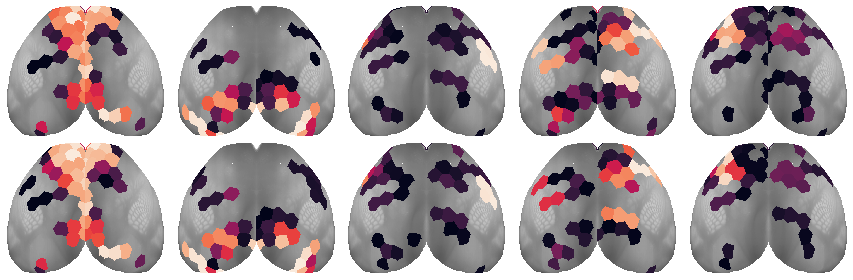

In [71]:
tr = gr.project_vec(pi)
tr = gr.trim2d(tr)
quick_show(tr2, tr)

In [72]:
data.shape

(2440, 154)

In [73]:
pi_all = self._cat_data(raw=False, which='pi')
pi_all.shape

(488, 5, 154)

In [74]:
mu = pi_all.mean(0)
sd = pi_all.std(0, ddof=1)

In [76]:
%%time
boot = bootstrap(
    x=pi_all,
    n_resamples=int(1e4),
    dims={'seed': len(pi_all)},
    est=bn.nanmean,
)
se = bn.nanstd(boot, axis=0, ddof=1)
boot.shape, se.shape

CPU times: user 15.8 s, sys: 26 ms, total: 15.8 s
Wall time: 15.8 s


((10000, 5, 154), (5, 154))

In [77]:
tval = sp_stats.t.ppf(0.995, 499)
lower = mu - tval * se

In [78]:
reject = lower < 0.003
reject.sum()

271

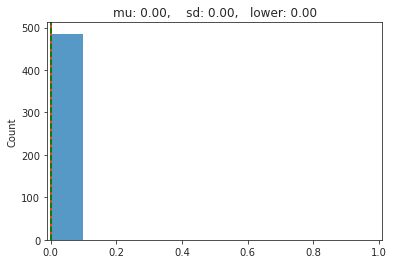

In [79]:
k = 4
n = 137
sns.histplot(pi_all[:, k, n], bins=np.linspace(0, 1, 11))
plt.title(f"mu: {mu[k, n]:0.2f},    sd: {sd[k, n]:0.2f},   lower: {lower[k, n]:0.2f}")
plt.axvline(mu[k, n], color='r', ls='-')
plt.axvline(mu[k, n] + sd[k, n], color='g', ls='--')
plt.axvline(mu[k, n] - sd[k, n], color='g', ls='--')
plt.xlim(-0.01, 1.01)
plt.show()

<AxesSubplot:ylabel='Count'>

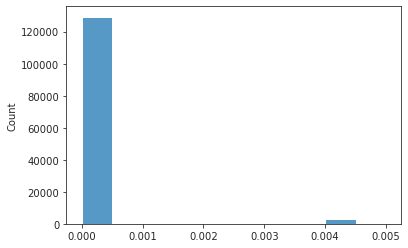

In [80]:
sns.histplot(pi_all[:, reject].ravel(), bins=np.linspace(0, 0.005, 11))

In [81]:
gam_all_0 = self._cat_data(raw=False, which='gam')
gam_all_0[:, reject] = 0.
gam = bn.nanmean(gam_all_0, 0)
pi = gam / np.nansum(gam, -2, keepdims=True)

In [82]:
gam_all = dc(gam_all_0)

In [83]:
nonzero = gam_all.sum(-2, keepdims=True) != 0
original_shape = gam_all.shape
ner = Normalizer()
gam_all = ner.fit_transform(
    gam_all.reshape(original_shape[0], -1))
gam_all = gam_all.reshape(original_shape)
gam_all *= self.num_k * original_shape[-1]
gam_all = np.where(nonzero, gam_all, np.nan)

In [84]:
np.unique(gam_all[:, 4, 137])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

In [85]:
centroids = np.nanmean(gam_all, -3)
nonan = np.where(np.isnan(centroids).sum(0) == 0)[0]
perms = find_best_mappings(
    centroids=ner.fit_transform(centroids[:, nonan]),
    data={
        i: ner.fit_transform(gam_all[i][:, nonan])
        for i in range(original_shape[0])},
    match_metric='correlation',
    global_order=True,
    filter_nans=True,
)

In [86]:
gam_all_final = np.zeros_like(gam_all_0)

for i, v in perms.items():
    mapping_ids = list(v.values())
    if mapping_ids != list(range(self.num_k)):
        print(i, v, mapping_ids)
        gam_all_final[i, ...] = gam_all_0[i, mapping_ids, :]

2
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

5
{0: 0, 1: 1, 2: 4, 3: 3, 4: 2}
[0, 1, 4, 3, 2]

34
{0: 0, 1: 1, 2: 3, 3: 2, 4: 4}
[0, 1, 3, 2, 4]

64
{0: 0, 1: 1, 2: 4, 3: 2, 4: 3}
[0, 1, 4, 2, 3]

88
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

107
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

111
{0: 2, 1: 1, 2: 0, 3: 3, 4: 4}
[2, 1, 0, 3, 4]

128
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

135
{0: 2, 1: 1, 2: 0, 3: 3, 4: 4}
[2, 1, 0, 3, 4]

138
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

165
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

184
{0: 0, 1: 3, 2: 2, 3: 4, 4: 1}
[0, 3, 2, 4, 1]

188
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

204
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

224
{0: 2, 1: 1, 2: 3, 3: 0, 4: 4}
[2, 1, 3, 0, 4]

247
{0: 0, 1: 1, 2: 4, 3: 3, 4: 2}
[0, 1, 4, 3, 2]

306
{0: 0, 1: 2, 2: 1, 3: 3, 4: 4}
[0, 2, 1, 3, 4]

316
{0: 0, 1: 1, 2: 3, 3: 2, 4: 4}
[0, 1, 3, 2, 4]

323
{0: 4, 1: 1, 2: 2, 3: 3, 4: 0}
[4, 1, 2, 3, 0]

327
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

399
{0: 3, 1: 1, 2: 2, 3: 0, 4: 4}
[3, 1, 2, 0, 4]

414
{0: 0, 1: 1, 2: 3, 3: 2, 4: 4}
[0, 1, 3, 2, 4]

438
{0: 0, 1: 1, 2: 3, 3: 2, 4: 4}
[0, 1, 3, 2, 4]

453
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

483
{0: 4, 1: 1, 2: 0, 3: 3, 4: 2}
[4, 1, 0, 3, 2]

486
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

In [87]:
gam_final = bn.nanmean(gam_all_final, 0)
pi_final = gam_final / np.nansum(gam_final, -2, keepdims=True)
pi_final.shape

(5, 154)

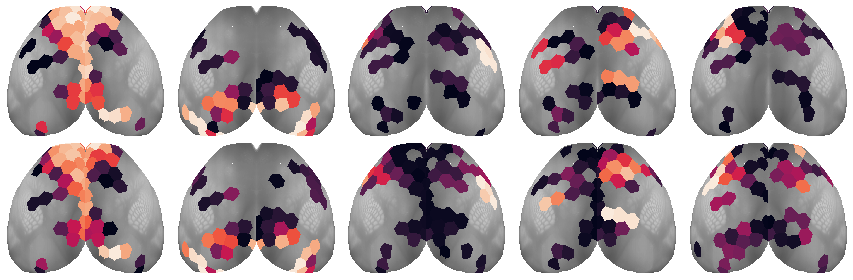

In [88]:
tr = gr.project_vec(pi)
tr = gr.trim2d(tr)

tr_final = gr.project_vec(pi_final)
tr_final = gr.trim2d(tr_final)
quick_show(tr, tr_final)

In [89]:
reject.sum()

271

## Check group

In [3]:
mice = Mice(128)

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
    'centroids_from': 'runs',
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [4]:
gr_bo = Group(**props_bo)
gr_ca = Group(**props_ca)

# svinets_bo = gr_bo.load_svinets()
# svinets_ca = gr_ca.load_svinets()

In [5]:
%%time

svinets_bo, perms_bo, centroids_bo = gr_bo.align_group()
svinets_ca, perms_ca, centroids_ca = gr_ca.align_group()

CPU times: user 5min 6s, sys: 7.37 s, total: 5min 13s
Wall time: 1min 11s


In [6]:
tr_bo = centroids_bo / np.nansum(centroids_bo, -2, keepdims=True)
tr_bo = gr_bo.project_vec(tr_bo)
tr_bo = gr_bo.trim2d(tr_bo)

tr_ca = centroids_ca / np.nansum(centroids_ca, -2, keepdims=True)
tr_ca = gr_ca.project_vec(tr_ca)
tr_ca = gr_ca.trim2d(tr_ca)

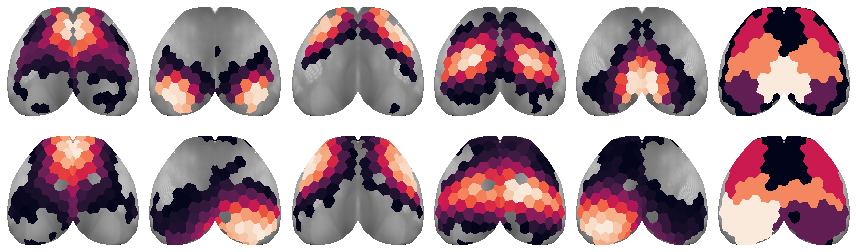

In [7]:
quick_show(tr_ca, tr_bo, 0.05)

In [8]:
data_ca = gr_ca.apply_perms(svinets_ca, perms_ca)

In [9]:
results_agg_ca = gr_ca.get_aggregate_data(data_ca, svinets_ca)

In [51]:
ctd_ca = results_agg_ca['centroids'].copy()
ctd_ca_avg = bn.nanmean(bn.nanmean(bn.nanmean(ctd_ca, 2), 1), 0)
ctd_ca.shape, ctd_ca_avg.shape

((10, 3, 4, 5, 154), (5, 154))

In [52]:
ner = Normalizer()

ctd_ca_reord = np_nans(ctd_ca.shape)

looper = itertools.product(range(10), range(3), range(4))
for i, j, k in looper:
    x = ctd_ca[i, j, k]
    good_nodes = np.where(np.isnan(x).sum(0) == 0)[0]
    if not len(good_nodes):
        continue
    pperm = find_best_mappings(
        data={'data': x[:, good_nodes]},
        centroids=ner.fit_transform(ctd_ca_avg[:, good_nodes]),
        match_metric='correlation',
        global_order=True,
    )['data']
    ctd_ca_reord[i, j, k] = x[list(pperm.values())]
    
ctd_ca_reord_avg = bn.nanmean(bn.nanmean(bn.nanmean(ctd_ca_reord, 2), 1), 0)
ctd_ca_reord_avg.shape

(5, 154)

In [53]:
pi_ca = ctd_ca_avg / np.nansum(ctd_ca_avg, -2, keepdims=True)
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

In [54]:
pi_ca_reord = ctd_ca_reord_avg / np.nansum(ctd_ca_reord_avg, -2, keepdims=True)
tr_ca_reord = gr_ca.project_vec(pi_ca_reord)
tr_ca_reord = gr_ca.trim2d(tr_ca_reord)

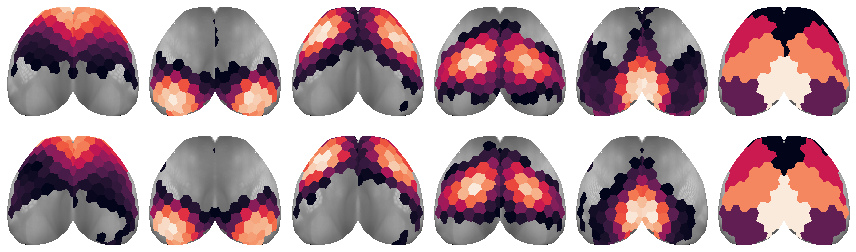

In [55]:
quick_show(tr_ca, tr_ca_reord)

In [56]:
data_bo = gr_bo.apply_perms(svinets_bo, perms_bo)

In [57]:
results_agg_bo = gr_bo.get_aggregate_data(data_bo, svinets_bo)

In [58]:
ctd_bo = results_agg_bo['centroids'].copy()
ctd_bo_avg = bn.nanmean(bn.nanmean(bn.nanmean(ctd_bo, 2), 1), 0)
ctd_bo.shape, ctd_bo_avg.shape

((10, 3, 4, 5, 154), (5, 154))

In [59]:
ner = Normalizer()

ctd_bo_reord = np_nans(ctd_bo.shape)

looper = itertools.product(range(10), range(3), range(4))
for i, j, k in looper:
    x = ctd_bo[i, j, k]
    good_nodes = np.where(np.isnan(x).sum(0) == 0)[0]
    if not len(good_nodes):
        continue
    pperm = find_best_mappings(
        data={'data': x[:, good_nodes]},
        centroids=ner.fit_transform(ctd_bo_avg[:, good_nodes]),
        match_metric='correlation',
        global_order=True,
    )['data']
    ctd_bo_reord[i, j, k] = x[list(pperm.values())]
    
ctd_bo_reord_avg = bn.nanmean(bn.nanmean(bn.nanmean(ctd_bo_reord, 2), 1), 0)
ctd_bo_reord_avg.shape

(5, 154)

In [60]:
pi_bo = ctd_bo_avg / np.nansum(ctd_bo_avg, -2, keepdims=True)
tr_bo = gr_bo.project_vec(pi_bo)
tr_bo = gr_bo.trim2d(tr_bo)

In [61]:
pi_bo_reord = ctd_bo_reord_avg / np.nansum(ctd_bo_reord_avg, -2, keepdims=True)
tr_bo_reord = gr_bo.project_vec(pi_bo_reord)
tr_bo_reord = gr_bo.trim2d(tr_bo_reord)

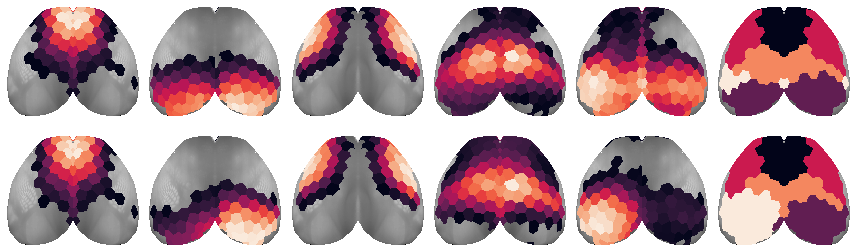

In [62]:
quick_show(tr_bo, tr_bo_reord)

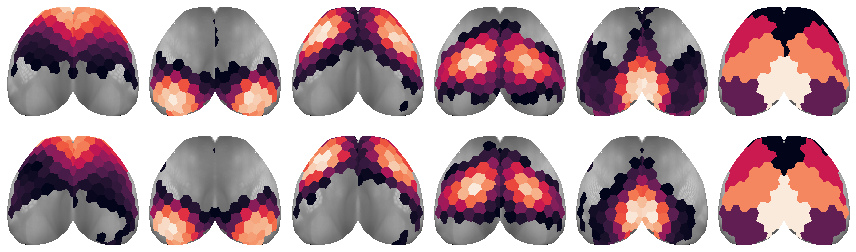

In [71]:
h_bo = sp_stats.entropy(pi_bo, axis=0) / np.log(5)
h_reord_bo = sp_stats.entropy(pi_bo_reord, axis=0) / np.log(5)

h_ca = sp_stats.entropy(pi_ca, axis=0) / np.log(5)
h_reord_ca = sp_stats.entropy(pi_ca_reord, axis=0) / np.log(5)

h = np.concatenate([np.expand_dims(h_ca, 0), np.expand_dims(h_bo, 0)])
h_reord = np.concatenate([np.expand_dims(h_reord_ca, 0), np.expand_dims(h_reord_bo, 0)])

tr_h = gr_ca.project_vec(h)
tr_h = gr_ca.trim2d(tr_h)

tr_h_reord = gr_ca.project_vec(h_reord)
tr_h_reord = gr_ca.trim2d(tr_h_reord)

In [87]:
sp_stats.pearsonr(h_bo, h_ca), sp_stats.pearsonr(h_reord_bo, h_reord_ca)

(
    (0.3114014471198811, 8.455631457561371e-05),
    (0.08366115197308562, 0.3022789348053852)
)

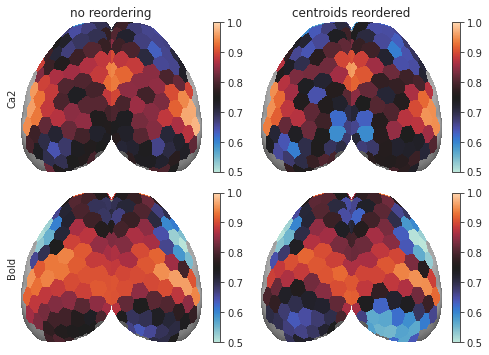

In [84]:
kwargs = {'cmap': 'icefire', 'vmin': 0.5, 'vmax': 1}

fig, axes = create_figure(2, 2, (7, 5))
for i in range(2):
    ax = axes[i, 0]
    ax.imshow(mwh(tr_h['top'] == 0, tr_h['top']), cmap='Greys_r')
    im = ax.imshow(mwh(tr_h['proj-top'][i] == 0, tr_h['proj-top'][i]), **kwargs)
    plt.colorbar(im, ax=ax)
    if i == 0:
        ax.set_title('no reordering')
    
    ax = axes[i, 1]
    ax.imshow(mwh(tr_h_reord['top'] == 0, tr_h_reord['top']), cmap='Greys_r')
    im = ax.imshow(mwh(tr_h_reord['proj-top'][i] == 0, tr_h_reord['proj-top'][i]), **kwargs)
    plt.colorbar(im, ax=ax)
    if i == 0:
        ax.set_title('centroids reordered')
    
axes[0, 0].set_ylabel('Ca2')
axes[1, 0].set_ylabel('Bold')

remove_ticks(axes)

<matplotlib.colorbar.Colorbar object at 0x7fb580d5fd00>

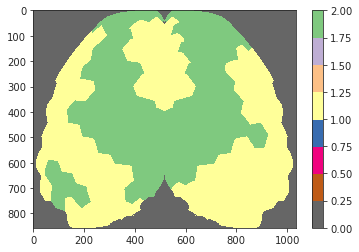

In [101]:
plt.imshow(tr_h_reord['proj-top'][2], cmap='Accent_r')
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7fb5a2429a30>

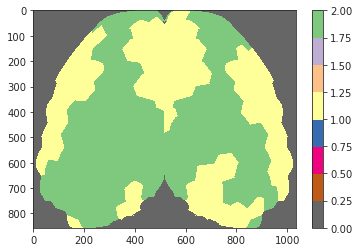

In [102]:
plt.imshow(tr_h['proj-top'][2], cmap='Accent_r')
plt.colorbar()

In [103]:
diff = np.concatenate([
    np.abs(h_bo - h_ca).reshape(1, -1),
    np.abs(h_reord_bo - h_reord_ca).reshape(1, -1)
])
diff = gr_ca.project_vec(diff)
diff = gr_ca.trim2d(diff)

<matplotlib.image.AxesImage object at 0x7fb5a38b7dc0>

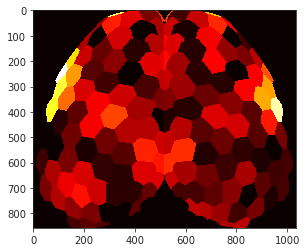

In [105]:
plt.imshow(diff['proj-top'][0], cmap='hot')

<matplotlib.image.AxesImage object at 0x7fb5a38cf2b0>

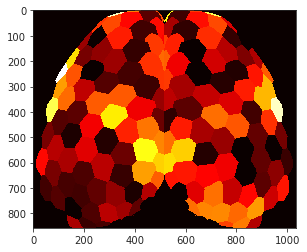

In [106]:
plt.imshow(diff['proj-top'][1], cmap='hot')

In [7]:
svinets = gr_ca.load_svinets()

In [8]:
node_in_runs = collections.defaultdict(list)
ctr = 0
for key, sv in svinets.items():
    if 'run' not in key:
        continue
    ctr += 1
    good_nodes = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    for n in good_nodes:
        node_in_runs[n].append(key)
node_in_runs = dict(sorted(node_in_runs.items()))
node_freq_good = {n: len(key_list) / ctr * 100 for n, key_list in node_in_runs.items()}

In [39]:
freq_thres = 90
good_global_nodes = [n for n, f in node_freq_good.items() if f > freq_thres]
len(good_global_nodes)

98

In [19]:
good_global_nodes

[
    0,
    1,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    76,
    77,
    78,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    88,
    89,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    99,
    100,
    101,
    102,
    103,
    104,
    105,
    106,
    107,
    108,
    109,
    111,
    112,
    113,
    114,
    115,
    116,
    117,
    118,
    119,
    120,
    121,
    122,
    123,
    124,
    125,
    126,
    127,
    128,
    129,
    130,
    131,
    132,
    133,
    134,
    135,
    136,
    137,
    138,
    140,
    141,
    142,
    143,
    144,
    145,
    146,
    147,
    149,
    150,
    151,
    152,
    153
]

In [40]:
accepted_runs = []
for key, sv in svinets.items():
    if 'run' not in key:
        continue
    good_nodes = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    accept = all(e in good_nodes for e in good_global_nodes)
    if accept:
        accepted_runs.append(key)
len(accepted_runs), ctr

(54, 111)

In [41]:
svinets = gr_ca.load_svinets()
unord = {
    key: sv.gam_all.reshape(-1, len(self.n2l))
    for key, sv in svinets.items()
    if key in accepted_runs
}
which_keys = self._get_keys_to_use()
data = [
    v for k, v in unord.items()
    if k in which_keys
]
data = np.concatenate(data)
nonan = np.where(np.isnan(data).sum(0) == 0)[0]

data.shape, len(nonan)

((134820, 154), 99)

In [42]:
centroids = np_nans((5, data.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=5,
    match_metric='euclidean',
    random_state=self.mice.cfg.random_state,
)
centroids[:, nonan] = _centroids

In [43]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=centroids,
    dist_metric=self.dist_metric,
    global_order=self.global_order,
)

In [44]:
centroids_before = dc(centroids)

In [45]:
centroids = centroids[global_mapping]
ner = Normalizer()
data_clean = {}

In [46]:
tr1 = centroids_before / np.nansum(centroids_before, -2, keepdims=True)
tr1 = gr_ca.project_vec(tr1)
tr1 = gr_ca.trim2d(tr1)

tr2 = centroids / np.nansum(centroids, -2, keepdims=True)
tr2 = gr_ca.project_vec(tr2)
tr2 = gr_ca.trim2d(tr2)

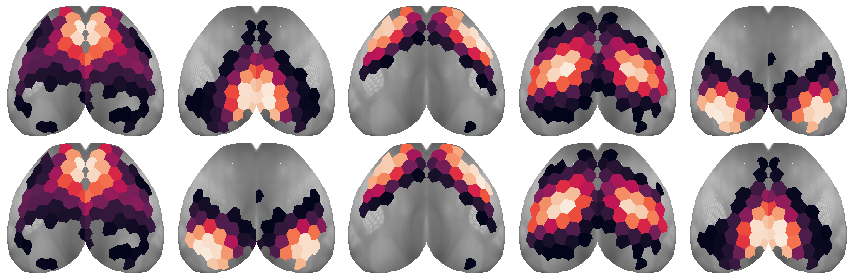

In [47]:
quick_show(tr1, tr2, 0.05)

In [6]:
self = gr_bo

In [7]:
svinets = self.load_svinets()

In [8]:
node_in_runs = collections.defaultdict(list)
ctr = 0
for key, sv in svinets.items():
    if 'run' not in key:
        continue
    ctr += 1
    good_nodes = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    for n in good_nodes:
        node_in_runs[n].append(key)
node_in_runs = dict(sorted(node_in_runs.items()))
node_freq_good = {n: len(key_list) / ctr * 100 for n, key_list in node_in_runs.items()}

In [9]:
freq_thres = 90
good_global_nodes = [n for n, f in node_freq_good.items() if f > freq_thres]
len(good_global_nodes)

148

In [10]:
accepted_runs = []
for key, sv in svinets.items():
    if 'run' not in key:
        continue
    good_nodes = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    accept = all(e in good_nodes for e in good_global_nodes)
    if accept:
        accepted_runs.append(key)
len(accepted_runs), ctr

(43, 115)

In [11]:
unord = {
    key: sv.gam_all.reshape(-1, len(self.n2l))
    for key, sv in svinets.items()
    if key in accepted_runs
}
which_keys = self._get_keys_to_use()
data = [
    v for k, v in unord.items()
    if k in which_keys
]
data = np.concatenate(data)
nonan = np.where(np.isnan(data).sum(0) == 0)[0]

data.shape, len(nonan)

((107475, 154), 148)

In [12]:
centroids = np_nans((5, data.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=5,
    match_metric='euclidean',
    random_state=self.mice.cfg.random_state,
)
centroids[:, nonan] = _centroids

In [13]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=centroids,
    dist_metric=self.dist_metric,
    global_order=self.global_order,
)

In [14]:
centroids_before = dc(centroids)

In [15]:
centroids = centroids[global_mapping]
ner = Normalizer()
data_clean = {}

In [16]:
tr1 = centroids_before / np.nansum(centroids_before, -2, keepdims=True)
tr1 = gr_ca.project_vec(tr1)
tr1 = gr_ca.trim2d(tr1)

tr2 = centroids / np.nansum(centroids, -2, keepdims=True)
tr2 = gr_ca.project_vec(tr2)
tr2 = gr_ca.trim2d(tr2)

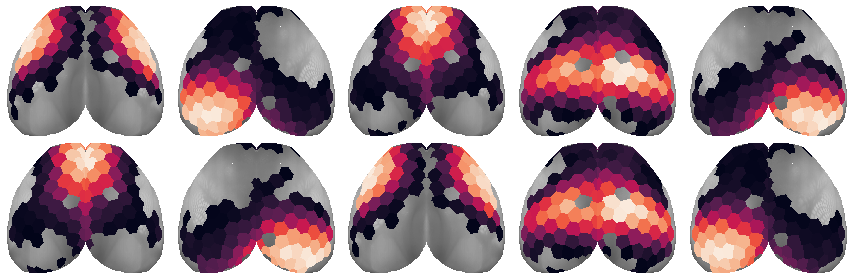

In [17]:
quick_show(tr1, tr2, 0.05)

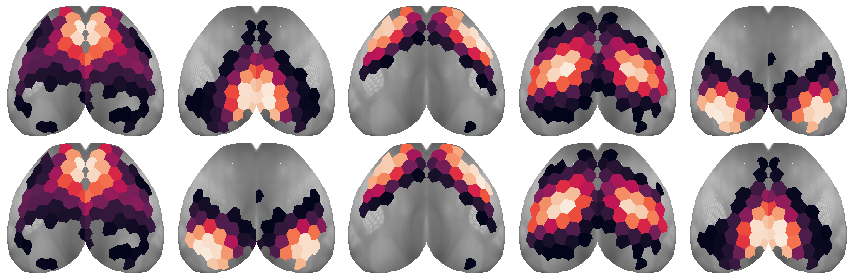

In [27]:
for k, x in unord.items():
    _x = x[:, nonan]
    _x = np.where(~np.isnan(_x), _x, 0.0)
    data_clean[k] = ner.fit_transform(_x)
perms = find_best_mappings(
    centroids=ner.fit_transform(centroids[:, nonan]),
    data=data_clean,
    match_metric='correlation',
    global_order=True,
)

In [28]:
self.perms = perms

In [29]:
permuted = self.apply_perms(svinets, perms)

In [38]:
permuted['sub-SLC05_ses-1_run-7']['gam'].shape

(494, 5, 154)